## Rebuild the parametrized circuit in AWS Braket

In [5]:
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import ParameterVector
from qiskit.primitives import BackendEstimator, Estimator, Sampler, BackendSampler

from braket.devices import LocalSimulator
from braket.circuits import Circuit, Gate, Instruction, QubitSet, AngledGate, Observable
from braket.circuits import noises
from braket.circuits.gates import X, Y, Z, Rx, Rz, CNot, XY, PulseGate, U, XX, ZZ
from braket.quantum_information import PauliString
from braket.parametric import FreeParameter, FreeParameterExpression
from braket.circuits.observables import TensorProduct

from qiskit_braket_provider.providers import adapter
from qiskit_braket_provider import AWSBraketProvider


In [6]:
action_vector = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5]) # np.random.uniform(-np.pi, np.pi, 7)

Qiskit implementation of ``parametrized_circuit``

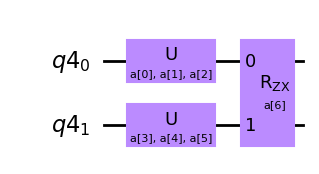

In [7]:
q_reg = QuantumRegister(2)
baseline = np.pi * np.zeros(len(action_vector))
params = ParameterVector("a", 7)
qiskit_circuit = QuantumCircuit(q_reg, name="custom_cx")
# optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
optimal_params = np.pi * np.zeros(7)

qiskit_circuit.u(
    baseline[0] + params[0],
    baseline[1] + params[1],
    baseline[2] + params[2],
    q_reg[0],
)
qiskit_circuit.u(
    baseline[3] + params[3],
    baseline[4] + params[4],
    baseline[5] + params[5],
    q_reg[1],
)

qiskit_circuit.rzx(baseline[6] + params[6], q_reg[0], q_reg[1])
qiskit_circuit.draw("mpl")

Conversion of Qiskit circuit to Braket circuit

In [8]:
braket_circuit_converted = adapter.convert_qiskit_to_braket_circuit(qiskit_circuit)

print(braket_circuit_converted)

T  : |       0        |1|2|   3   |4|5|
                                       
q0 : -U(a_0, a_1, a_2)---C---------C---
                         |         |   
q1 : -U(a_3, a_4, a_5)-H-X-Rz(a_6)-X-H-

T  : |       0        |1|2|   3   |4|5|

Unassigned parameters: [a_0, a_1, a_2, a_3, a_4, a_5, a_6].


#### Braket Version

In [9]:
braket_circuit = Circuit()

baseline = np.pi * np.zeros(len(action_vector))
params = [FreeParameter(f"a{i}") for i in range(0, len(action_vector))]

u1 = U(
    baseline[0] + params[0], 
    baseline[1] + params[1], 
    baseline[1] + params[2],
)
u2 = U(
    baseline[3] + params[3], 
    baseline[4] + params[4], 
    baseline[5] + params[5],
)

# rzx = RZX(
#     baseline[6] + params[6]
# )

braket_circuit.add_instruction(Instruction(u1, [0]))
braket_circuit.add_instruction(Instruction(u2, [1]))
print(braket_circuit)

T  : |      0      |
                    
q0 : -U(a0, a1, a2)-
                    
q1 : -U(a3, a4, a5)-

T  : |      0      |

Unassigned parameters: [a0, a1, a2, a3, a4, a5].


In [10]:
def rzx(theta, register):
    """
    RZX gate decomposition for angle theta
    """
    q1, q2 = register
    qc = Circuit()

    # Step 1: Apply Hadamard gate to the target qubit
    qc.h(q2)

    # Step 2: Apply CNOT gate with q1 as control and q2 as target
    qc.cnot(q1, q2)

    # Step 3: Apply RZ gate with angle theta to the target qubit
    # Since Braket's RZ gate uses full angle, there's no need to divide theta by 2
    qc.rz(q2, angle=theta)

    # Step 4: Apply another CNOT gate with q1 as control and q2 as target
    qc.cnot(q1, q2)

    # Step 5: Apply Hadamard gate to the target qubit again
    qc.h(q2)
    
    return qc

Circuit.register_subroutine(rzx)

braket_circuit.rzx(baseline[6] + params[6], [0, 1])

print(braket_circuit)

T  : |      0      |1|2|  3   |4|5|
                                   
q0 : -U(a0, a1, a2)---C--------C---
                      |        |   
q1 : -U(a3, a4, a5)-H-X-Rz(a6)-X-H-

T  : |      0      |1|2|  3   |4|5|

Unassigned parameters: [a0, a1, a2, a3, a4, a5, a6].


Sanity Checks if RZX was correclty implemented

In [11]:
sigma_x = np.array([[0, 1], [1, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

new_circ = Circuit()
check1 = np.isclose(new_circ.rzx(0, [0, 1]).to_unitary(), np.eye(4), atol=1e-8)
new_circ = Circuit()
check2 = np.isclose(new_circ.rzx(2*np.pi, [0, 1]).to_unitary(), -np.eye(4), atol=1e-8)
new_circ = Circuit()
check3 = np.isclose(new_circ.rzx(np.pi, [0, 1]).to_unitary(), -1j * np.kron(sigma_z, sigma_x), atol=1e-8)

if check1.all() and check2.all() and check3.all():
    print("RZX gate is implemented correctly!")

RZX gate is implemented correctly!


In [12]:
device = LocalSimulator() # Noise-Free statevector simulation
n_shots = 1000

# device = LocalSimulator(backend="braket_dm") # For simulations with noise

In [13]:
param_names = [str(param) for param in params]
bound_parameters = dict(zip(param_names, action_vector))

print('Braket Circuit: \n\n', braket_circuit)
print('\n\nQiskit to Braket Circuit Conversion: \n\n', braket_circuit_converted)
print('\n\nConverted circuit and native Braket circuit are equivalent:', braket_circuit == braket_circuit_converted)
if braket_circuit != braket_circuit_converted:
    raise ValueError('Circuit conversion failed')

Braket Circuit: 

 T  : |      0      |1|2|  3   |4|5|
                                   
q0 : -U(a0, a1, a2)---C--------C---
                      |        |   
q1 : -U(a3, a4, a5)-H-X-Rz(a6)-X-H-

T  : |      0      |1|2|  3   |4|5|

Unassigned parameters: [a0, a1, a2, a3, a4, a5, a6].


Qiskit to Braket Circuit Conversion: 

 T  : |       0        |1|2|   3   |4|5|
                                       
q0 : -U(a_0, a_1, a_2)---C---------C---
                         |         |   
q1 : -U(a_3, a_4, a_5)-H-X-Rz(a_6)-X-H-

T  : |       0        |1|2|   3   |4|5|

Unassigned parameters: [a_0, a_1, a_2, a_3, a_4, a_5, a_6].


Converted circuit and native Braket circuit are equivalent: False


ValueError: Circuit conversion failed

In [14]:
braket_circuit.parameters

{a0, a1, a2, a3, a4, a5, a6}

In [15]:
# run the circuit on the local simulator
task = device.run(
    braket_circuit, 
    shots=n_shots, 
    inputs=bound_parameters
)

# visualize the results
result = task.result()
measurement = result.measurement_counts
print('measurement results:', measurement)

measurement results: Counter({'00': 1000})


In [16]:
obs = 0.5*Observable.Z()
obs.coefficient

0.5

### AWSEstimator

In [17]:
class AWSEstimator:
    def __init__(self, backend):
        self.backend = backend

    def _validate_inputs(self, circuit, bound_parameters):
        """
        Validate the inputs to ensure the number of circuits matches the number of bound_parameters.

        :param circuit: A single QuantumCircuit or a list of QuantumCircuits.
        :param bound_parameters: A single dictionary of parameters or a list of dictionaries.
        :raises ValueError: If the number of circuits and parameter dictionaries do not match.
        """
        # Check if inputs are lists; if not, wrap them in a list
        if not isinstance(circuit, list):
            circuit = [circuit]
        if not isinstance(bound_parameters, list):
            bound_parameters = [bound_parameters]

        # Check if the number of circuits matches the number of parameter dictionaries
        if len(circuit) != len(bound_parameters):
            raise ValueError("The number of circuits must match the number of dictionaries of bound parameters.")

        
    def post_process(self, result, observables, coefficients=None):
        """
        Process the result from the quantum computation to extract and optionally scale the expectation values.

        :param result: The result object returned by the quantum computation.
        :param observables: A list of observables for which the expectation values were measured.
        :param coefficients: Optional list of coefficients to scale the expectation values of the observables.
                            This should be in the same order as the observables list.
        :return: A list of processed expectation values.
        """
        if not isinstance(result, list):
            expectation_values = []

            # If coefficients are provided, they must match the number of observables
            if coefficients and len([observables]) != len([coefficients]):
                raise ValueError("The number of coefficients must match the number of observables.")

            for i, observable in enumerate([observables]):
                # Extract the raw expectation value from the result object
                raw_expectation_value = result.values[i]  # Assuming result.values is a list of expectation values
            
                # Apply the coefficient if provided, else use the raw value
                if coefficients:
                    processed_value = coefficients[i] * raw_expectation_value
                else:
                    processed_value = raw_expectation_value

                expectation_values.append(processed_value)

            return expectation_values
        
        elif isinstance(result, list) and len(result) > 1:
            expectation_values = []
            for res in result:
                expectation_values.append(self.post_process(res, observables, coefficients))
            return expectation_values

    def run(
        self, 
        circuit, 
        observables,
        op_coefficients: complex | list[complex] = [1.0],
        target_register: int | list[int] = [0],
        bound_parameters: dict = None,
        shots: int = 1000, 
        ):

        self._validate_inputs(circuit, bound_parameters)

        if isinstance(circuit, list) and len(circuit) > 1: # Batch execution
            for circ in circuit:
                circ.expectation(observable=observables, target=target_register)
            
            print('Running batch...')
            job = device.run_batch(circuit, inputs=bound_parameters, shots=n_shots)
            print('Finished running batch.')
            
            return list(job.results()), self.post_process(list(job.results()), observables, op_coefficients)
        
        else:
            circuit.expectation(observable=observables, target=target_register)
            
            if circuit.parameters:    
                job = self.backend.run(circuit, inputs=bound_parameters, shots=shots)
            else:
                job = self.backend.run(circuit, shots=shots)

            return job.result(), self.post_process(job.result(), observables, op_coefficients)


In [18]:
obs = Observable.Z() @ Observable.Z()
obs.qubit_count

2

In [80]:
estimator = AWSEstimator(device)
result, expvals = estimator.run(
    circuit=braket_circuit, 
    observables=Observable.X()@Observable.Y(),
    op_coefficients=[0.5], 
    target_register=[0, 1], 
    bound_parameters=bound_parameters, 
    shots=n_shots,
)

In [81]:
expvals

[0.019]

### Running Test Cases for the AWSEstimator

In [90]:
def test_post_process(estimator, circuit, observables, coefficients, correct_expval):

    _, estimator_expvals = estimator.run(
        circuit=circuit, 
        observables=observables,
        op_coefficients=coefficients,
        target_register=list(range(observables.qubit_count)),  # Assuming each observable targets one qubit
        shots=0,
    )

    # processed_values = estimator.post_process(result, observables, coefficients)
    correct_expval = [coeff * expval for coeff, expval in zip(coefficients, correct_expval)]

    assert estimator_expvals == correct_expval, "Processed values do not match expected output"


In [94]:
def run_test_cases(test_device = LocalSimulator()):
    estimator = AWSEstimator(backend=test_device)

    # Configuration for each test case: Circuit, Observable, Coefficients, Correct Expectation Value
    configurations = [
        # Test Case 1
        (
            Circuit().x(0),
            Observable.Z(),
            [-2.0],
            test_device.run(Circuit().x(0).expectation(Observable.Z(), target=0), shots=0).result().values
        ),
        # Test Case 2
        (
            Circuit().x(0).x(1),
            Observable.Z() @ Observable.Z(),
            [-1.0],  # Coefficient for this test case
            test_device.run(Circuit().x(0).x(1).expectation(Observable.Z() @ Observable.Z(), target=[0, 1]), shots=0).result().values
        ),
        # Test Case 3
        (
            Circuit().h(0).z(1),
            Observable.X() @ Observable.Y(),
            [1.0],  # Coefficient for this test case
            test_device.run(Circuit().h(0).z(1).expectation(Observable.X() @ Observable.Y(), target=[0, 1]), shots=0).result().values
        )
    ]

    # Iterate over each configuration and run the test
    for circuit, observables, coefficients, correct_expval in configurations:
        test_post_process(estimator, circuit, observables, coefficients, correct_expval)

run_test_cases()

In [66]:
# Native Braket Simulator result
test_device = LocalSimulator()
test_circuit = Circuit().x(0).x(1)
test_observable = Observable.Z()@Observable.Z()
test_circuit.expectation(observable=test_observable, target=[0, 1])
correct_expval = test_device.run(test_circuit, shots=0).result().values

In [ ]:
def test_post_process_with_coefficients():

    # Native Braket Simulator result
    test_device = LocalSimulator()
    test_circuit = Circuit().x(0)
    test_observable = Observable.Z()
    test_circuit.expectation(observable=test_observable, target=0)
    correct_expval = test_device.run(test_circuit, shots=0).result().values


    # Own Estimator result
    estimator = AWSEstimator(backend=test_device)
    coefficients = [-2.0]

    estimator_result, estimator_expvals = estimator.run(
        circuit=test_circuit, 
        observables=test_observable,
        op_coefficients=coefficients,
        target_register=[0],
        shots=0,
    )

    # processed_values = estimator.post_process(result, observables, coefficients)

    assert estimator_expvals == [correct_expval[0]*coefficients[0]], "Processed values do not match expected output"

test_post_process_with_coefficients()


### Measuring expectation values

In [11]:
from braket.circuits.observables import Sum

In [12]:
# TODO: Create a weighted sum of pauli observables

observable_string_xx = "XX"
observable_string_zz = "ZZ"

In [13]:
PauliString(observable_string_xx).to_unsigned_observable() + PauliString(observable_string_zz).to_unsigned_observable()

Sum(TensorProduct(X('qubit_count': 1), X('qubit_count': 1)), TensorProduct(Z('qubit_count': 1), Z('qubit_count': 1)))

In [14]:
pauli_operator = Sum(observables=[0.5 * PauliString(observable_string_xx).to_unsigned_observable(), 0.5 * PauliString(observable_string_zz).to_unsigned_observable()], display_name='0.5XX + 0.5ZZ')

In [15]:
pauli_operator.ascii_symbols

('0.5XX + 0.5ZZ', '0.5XX + 0.5ZZ')

In [16]:
list(pauli_operator.summands)[0].coefficient

0.5

#### Measure expectation values on the native braket circuit

In [17]:
# paulis = ExtendedPauliString(pauli_strings=['XX', 'ZZ'], coefficients=[0.5, 0.5])
# paulis.to_tensor_product()

In [18]:
temp = 0.5*Observable.X()
temp.ascii_symbols

('0.5X',)

In [19]:
t1 = 0.5 * Observable.X()
print(t1.ascii_symbols)
t1.to_matrix()


t2 = 0.5 * Observable.Z()
print(t2.ascii_symbols)
t2.to_matrix()

('0.5X',)
('0.5Z',)


array([[ 0.5+0.j,  0. +0.j],
       [ 0. +0.j, -0.5+0.j]])

In [20]:
observable = TensorProduct([t1, t2])

In [21]:
TensorProduct([t1, t2]).to_matrix()

array([[ 0.  +0.j,  0.  +0.j,  0.25+0.j,  0.  +0.j],
       [ 0.  +0.j, -0.  +0.j,  0.  +0.j, -0.25+0.j],
       [ 0.25+0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j],
       [ 0.  +0.j, -0.25+0.j,  0.  +0.j, -0.  +0.j]])

In [22]:
op = TensorProduct([Observable.X(), Observable.Z()])
# op = TensorProduct([Observable.X(), Observable.Z()])
op.ascii_symbols

('X@Z', 'X@Z')

In [23]:
# Create a small circuit with a free parameter theta
pauli_string = PauliString(observable_string_xx)
pauli_operator = pauli_string.to_unsigned_observable()

# braket_circuit.state_vector() # Get the state vector of the circuit # Can only be determined for shots=0
braket_circuit.expectation(observable=observable, target=[0, 1]) # Get the expectation value of the Pauli operator

# pauli_string = PauliString(observable_string_xx)
# pauli_operator = 0.5*pauli_string.to_unsigned_observable()
# braket_circuit.expectation(observable=pauli_operator, target=[0, 1]) 
print(braket_circuit)

# Small value for test purposes
# batchsize = 5
# batch_circuits = [circ] * batchsize

T  : |      0      |1|2|  3   |4|5|    Result Types    |
                                                        
q0 : -U(a0, a1, a2)---C--------C---Expectation(0.25X@Z)-
                      |        |   |                    
q1 : -U(a3, a4, a5)-H-X-Rz(a6)-X-H-Expectation(0.25X@Z)-

T  : |      0      |1|2|  3   |4|5|    Result Types    |

Unassigned parameters: [a0, a1, a2, a3, a4, a5, a6].


In [24]:
bound_parameters

{'a0': 0.0,
 'a1': 0.0,
 'a2': 1.5707963267948966,
 'a3': 1.5707963267948966,
 'a4': -1.5707963267948966,
 'a5': 1.5707963267948966,
 'a6': -1.5707963267948966}

In [25]:
job = device.run(braket_circuit, shots=n_shots, inputs=bound_parameters)

# Run multiple circuits at once
# job = device.run_batch(
#     batch_circuits,
#     inputs={'theta': thetas}, 
#     shots=100
# )

print('Measurement Counts:', job.result().measurement_counts)
print('Measurement Probabilities:', job.result().measurement_probabilities)

# print("Final EXACT state vector:\n", job.result().values[0])
print(f"Expectation value <XZ>:", np.round(job.result().values[0], 5))

line 1:26 mismatched input '0.25' expecting {'x', 'y', 'z', 'i', 'h', 'hermitian'}


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
from braket.circuits import Circuit, Observable
from braket.devices import LocalSimulator

# Define your Hamiltonian
observable = 0.25 * Observable.X() @ Observable.X() + 0.5 * Observable.Z() @ Observable.Z()

# Initialize your quantum circuit as needed
circuit = Circuit()
circuit.x(0)
# circuit.h(0).cnot(0, 1)

Circuit('instructions': [Instruction('operator': X('qubit_count': 1), 'target': QubitSet([Qubit(0)]), 'control': QubitSet([]), 'control_state': (), 'power': 1)])

In [ ]:
# Define observables for each qubit
observable_q0 = Observable.X() + Observable.X()
observable_q1 = Observable.Z() + Observable.Z()

# Measure the expectation value for the observable on qubit 0
circuit.expectation(observable=observable_q0, target=[[0], [0]])

# Measure the expectation value for the observable on qubit 1
circuit.expectation(observable=observable_q1, target=[[1], [1]])
print(circuit)

# Add your quantum gates to prepare the state |psi>
# For example, circuit.h(0).cnot(0, 1) to prepare an entangled state


# Set the device to run your circuit
device = LocalSimulator()

# Run the circuit with the observable to measure the expectation value
task = device.run(circuit, shots=1000)

# Get the result
result = task.result()

# # Extract the expectation value from the result
expectation_values = result.values

print(f"\nExpectation value: {expectation_values}")

T  : |0|      Result Types      |
                                 
q0 : -X-Expectation(Hamiltonian)-
                                 
q1 : ---Expectation(Hamiltonian)-

T  : |0|      Result Types      |

Expectation value: [-0.01, 1.0]


#### Run a small batch of braket cirucits with ``run_batch``

In [26]:
from braket.circuits import noises

In [27]:
device = LocalSimulator(backend='braket_dm', noise_model=noises.BitFlip(probability=0.1))

AttributeError: 'LocalSimulator' object has no attribute '_validate_device_noise_model_support'

In [19]:
batchsize = 5

# Create a list of circuits
batch_circuits = [braket_circuit] * batchsize

# Create a list of parameter dicts
batch_bound_parameters = [bound_parameters] * batchsize

In [126]:
len(batch_bound_parameters)

5

In [127]:
len(batch_circuits)

5

In [123]:
estimator = AWSEstimator(device)
batch_results = estimator.run(batch_circuits, Observable.Z(), [0], batch_bound_parameters, n_shots)

ValueError: The number of circuits must match the number of dictionaries of bound parameters.

In [ ]:
batch_results = device.run_batch(batch_circuits, inputs=batch_bound_parameters, shots=n_shots)

In [ ]:
for ind, result in enumerate(batch_results.results()):
    print('Batch Number:', ind+1)
    print('Measurement Counts:', result.measurement_counts)
    print('Measurement Probabilities:', result.measurement_probabilities)
    print(f"Expectation value <XZ>:", np.round(result.values[0], 5), '\n')

Batch Number: 0
Measurement Counts: Counter({'10': 505, '00': 495})
Measurement Probabilities: {'00': 0.495, '10': 0.505}
Expectation value <XZ>: -0.01 

Batch Number: 1
Measurement Counts: Counter({'00': 509, '10': 491})
Measurement Probabilities: {'00': 0.509, '10': 0.491}
Expectation value <XZ>: 0.018 

Batch Number: 2
Measurement Counts: Counter({'00': 538, '10': 462})
Measurement Probabilities: {'00': 0.538, '10': 0.462}
Expectation value <XZ>: 0.076 

Batch Number: 3
Measurement Counts: Counter({'00': 512, '10': 488})
Measurement Probabilities: {'10': 0.488, '00': 0.512}
Expectation value <XZ>: 0.024 

Batch Number: 4
Measurement Counts: Counter({'00': 505, '10': 495})
Measurement Probabilities: {'10': 0.495, '00': 0.505}
Expectation value <XZ>: 0.01 



#### Run same circuit with Qiskit Statevector Estimator

In [ ]:
from qiskit.primitives import Estimator
from qiskit.quantum_info.operators import SparsePauliOp

estimator = Estimator()
observable = SparsePauliOp(
    [observable_string_xx], # , observable_string_zz], 
    coeffs=[1.0] #, 1.0]
)

In [ ]:
qiskit_circuit.draw('mpl')

In [ ]:
qiskit_job = estimator.run(
    circuits=qiskit_circuit, 
    observables=observable, 
    parameter_values=action_vector,
    shots=n_shots
)

In [ ]:
def create_expectation_string(prefactors, observable_strings):
    if len(prefactors) != len(observable_strings):
        raise ValueError("The lengths of prefactors and observable_strings should be the same.")

    expectation_string = "Expectation value "
    for i in range(len(prefactors)):
        expectation_string += f"{prefactors[i]}*<{observable_strings[i]}>"
        if i < len(prefactors) - 1:
            expectation_string += " + "

    expectation_string += ":"

    return expectation_string

In [ ]:
print(create_expectation_string(observable.coeffs, observable.settings['data']), qiskit_job.result().values)

#### Create BackendEstimator out of Qiskit-Braket-Provider backend

In [ ]:
# backend = AWSBraketProvider().get_backend('SV1')
# qiskit_estimator_from_braket = BackendEstimator(backend)

# job = qiskit_estimator_from_braket.run(
#     circuits=qiskit_circuit, 
#     observables=observable, 
#     parameter_values=action_vector,
#     shots=n_shots
# )

In [ ]:
# job = qiskit_estimator_from_braket.run(
#     circuits=qiskit_circuit, 
#     observables=observable, 
#     parameter_values=action_vector,
#     shots=n_shots
# )

In [ ]:
# job.result().values

## Qiskit-Braket Provider Properties

In [85]:
backend = AWSBraketProvider().get_backend('SV1')

In [79]:
from qiskit.providers import BackendV2
from qiskit.providers.fake_provider import FakeJakartaV2

In [82]:
isinstance(backend, BackendV2)

True

In [84]:
backend.instruction_durations.duration_by_name_qubits

{}

In [86]:
backend_2 = FakeJakartaV2()
backend_2.instruction_durations.duration_by_name_qubits

{('id', (0,)): (3.5555555555555554e-08, 's'),
 ('id', (1,)): (3.5555555555555554e-08, 's'),
 ('id', (2,)): (3.5555555555555554e-08, 's'),
 ('id', (3,)): (3.5555555555555554e-08, 's'),
 ('id', (4,)): (3.5555555555555554e-08, 's'),
 ('id', (5,)): (3.5555555555555554e-08, 's'),
 ('id', (6,)): (3.5555555555555554e-08, 's'),
 ('rz', (0,)): (0.0, 's'),
 ('rz', (1,)): (0.0, 's'),
 ('rz', (2,)): (0.0, 's'),
 ('rz', (3,)): (0.0, 's'),
 ('rz', (4,)): (0.0, 's'),
 ('rz', (5,)): (0.0, 's'),
 ('rz', (6,)): (0.0, 's'),
 ('sx', (0,)): (3.5555555555555554e-08, 's'),
 ('sx', (1,)): (3.5555555555555554e-08, 's'),
 ('sx', (2,)): (3.5555555555555554e-08, 's'),
 ('sx', (3,)): (3.5555555555555554e-08, 's'),
 ('sx', (4,)): (3.5555555555555554e-08, 's'),
 ('sx', (5,)): (3.5555555555555554e-08, 's'),
 ('sx', (6,)): (3.5555555555555554e-08, 's'),
 ('x', (0,)): (3.5555555555555554e-08, 's'),
 ('x', (1,)): (3.5555555555555554e-08, 's'),
 ('x', (2,)): (3.5555555555555554e-08, 's'),
 ('x', (3,)): (3.555555555555555